In [1]:
import scanpy as sc

# Load the file
adata = sc.read_h5ad("data/dataset.h5ad")
adata = adata[adata.obs['cell_type'] == "glutamatergic neuron"].copy()

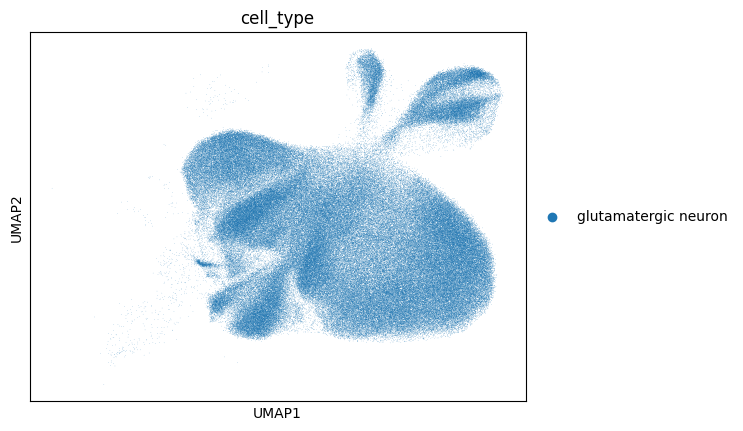

In [2]:
# Plot the cell population based on cell type
sc.pl.umap(adata, color=['cell_type'])

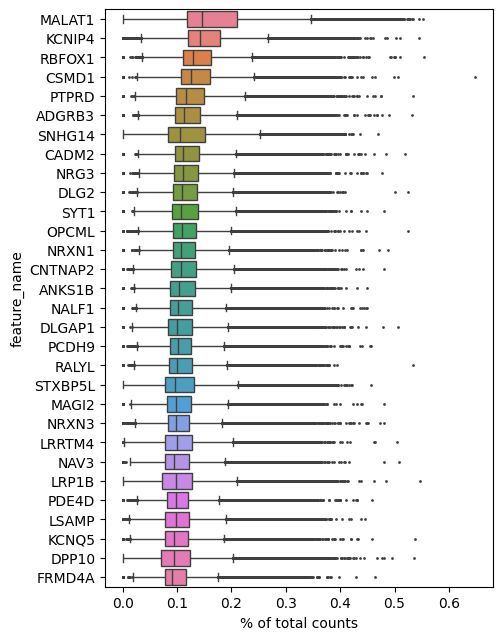

In [3]:
genes = sc.pl.highest_expr_genes(adata, gene_symbols="feature_name")

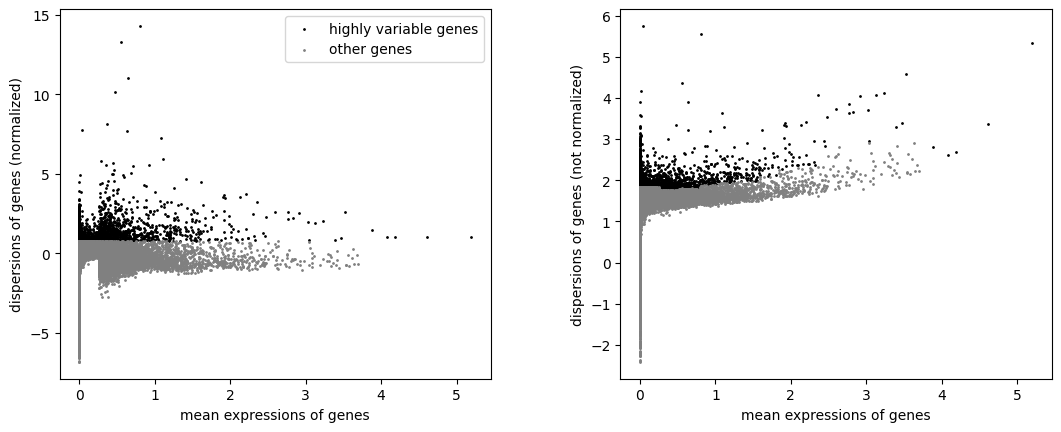

In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes=5000)
sc.pl.highly_variable_genes(adata)

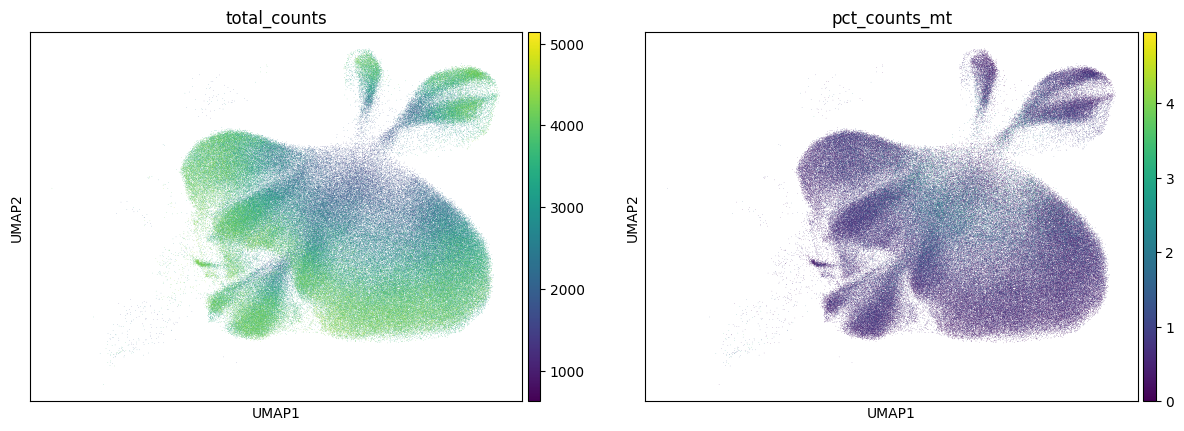

In [6]:
sc.pl.umap(
    adata,
    color=["total_counts", "pct_counts_mt"],
)

In [7]:
adata

AnnData object with n_obs × n_vars = 282930 × 61427
    obs: 'APOE_class', 'Brain.Region', 'SORT', 'Braak.stage', 'Disease.Group', 'Amyloid', 'Brain.weight', 'PMI.hr.', 'Race', 'Age', 'RIN', 'total_counts', 'pct_counts_mt', 'droplet_FDR', 'doublefinder', 'n_genes', 'sample', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'donor_id', 'Age_group', 'PMI_group', 'RIN_group', 'Major_celltypes', 'Author_Annotation', 'NP.Diagonis', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'mt', 'ribo', 'hb', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Author_Annotati

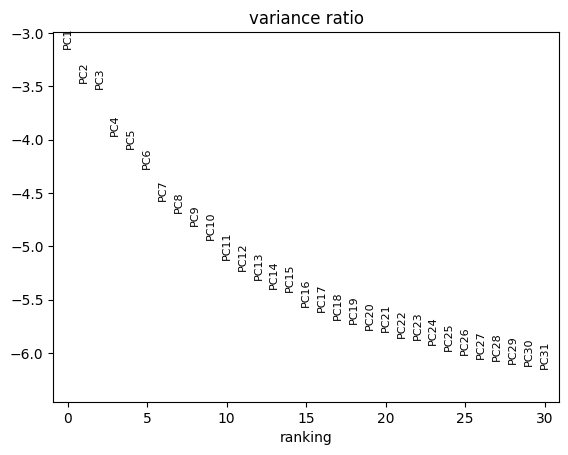

In [8]:
sc.tl.pca(adata, svd_solver='arpack', mask_var = "highly_variable")
sc.pl.pca_variance_ratio(adata, log=True)

In [9]:
adata_hvg = adata[:, adata.var['highly_variable']]

In [10]:
sc.pp.neighbors(adata_hvg, n_pcs=25)
sc.tl.umap(adata_hvg)

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
sc.tl.leiden(adata_hvg, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata_hvg, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata_hvg, key_added="leiden_res1", resolution=1.0)

/var/folders/m0/5342p_s55313vrcn64gwp8t80000gn/T/ipykernel_1256/2803219699.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_hvg, key_added="leiden_res0_25", resolution=0.25)


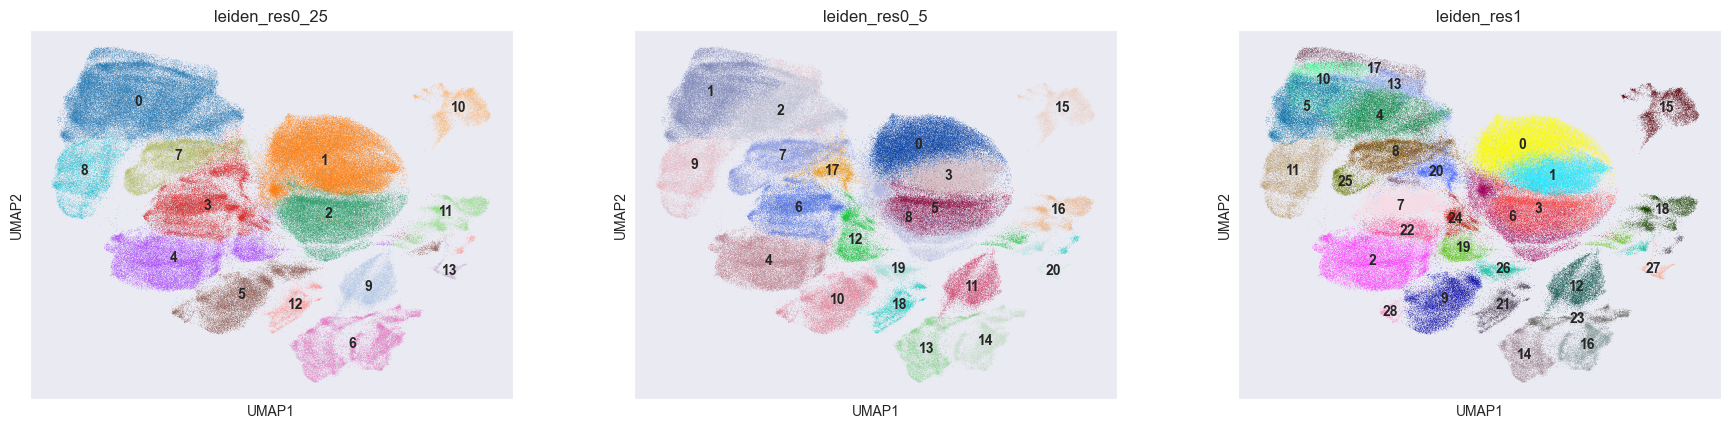

In [12]:
sc.pl.umap(
    adata_hvg,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
)

In [13]:
sc.tl.rank_genes_groups(adata_hvg, 'leiden_res0_5', method='wilcoxon', pts=True)

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:456: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/l

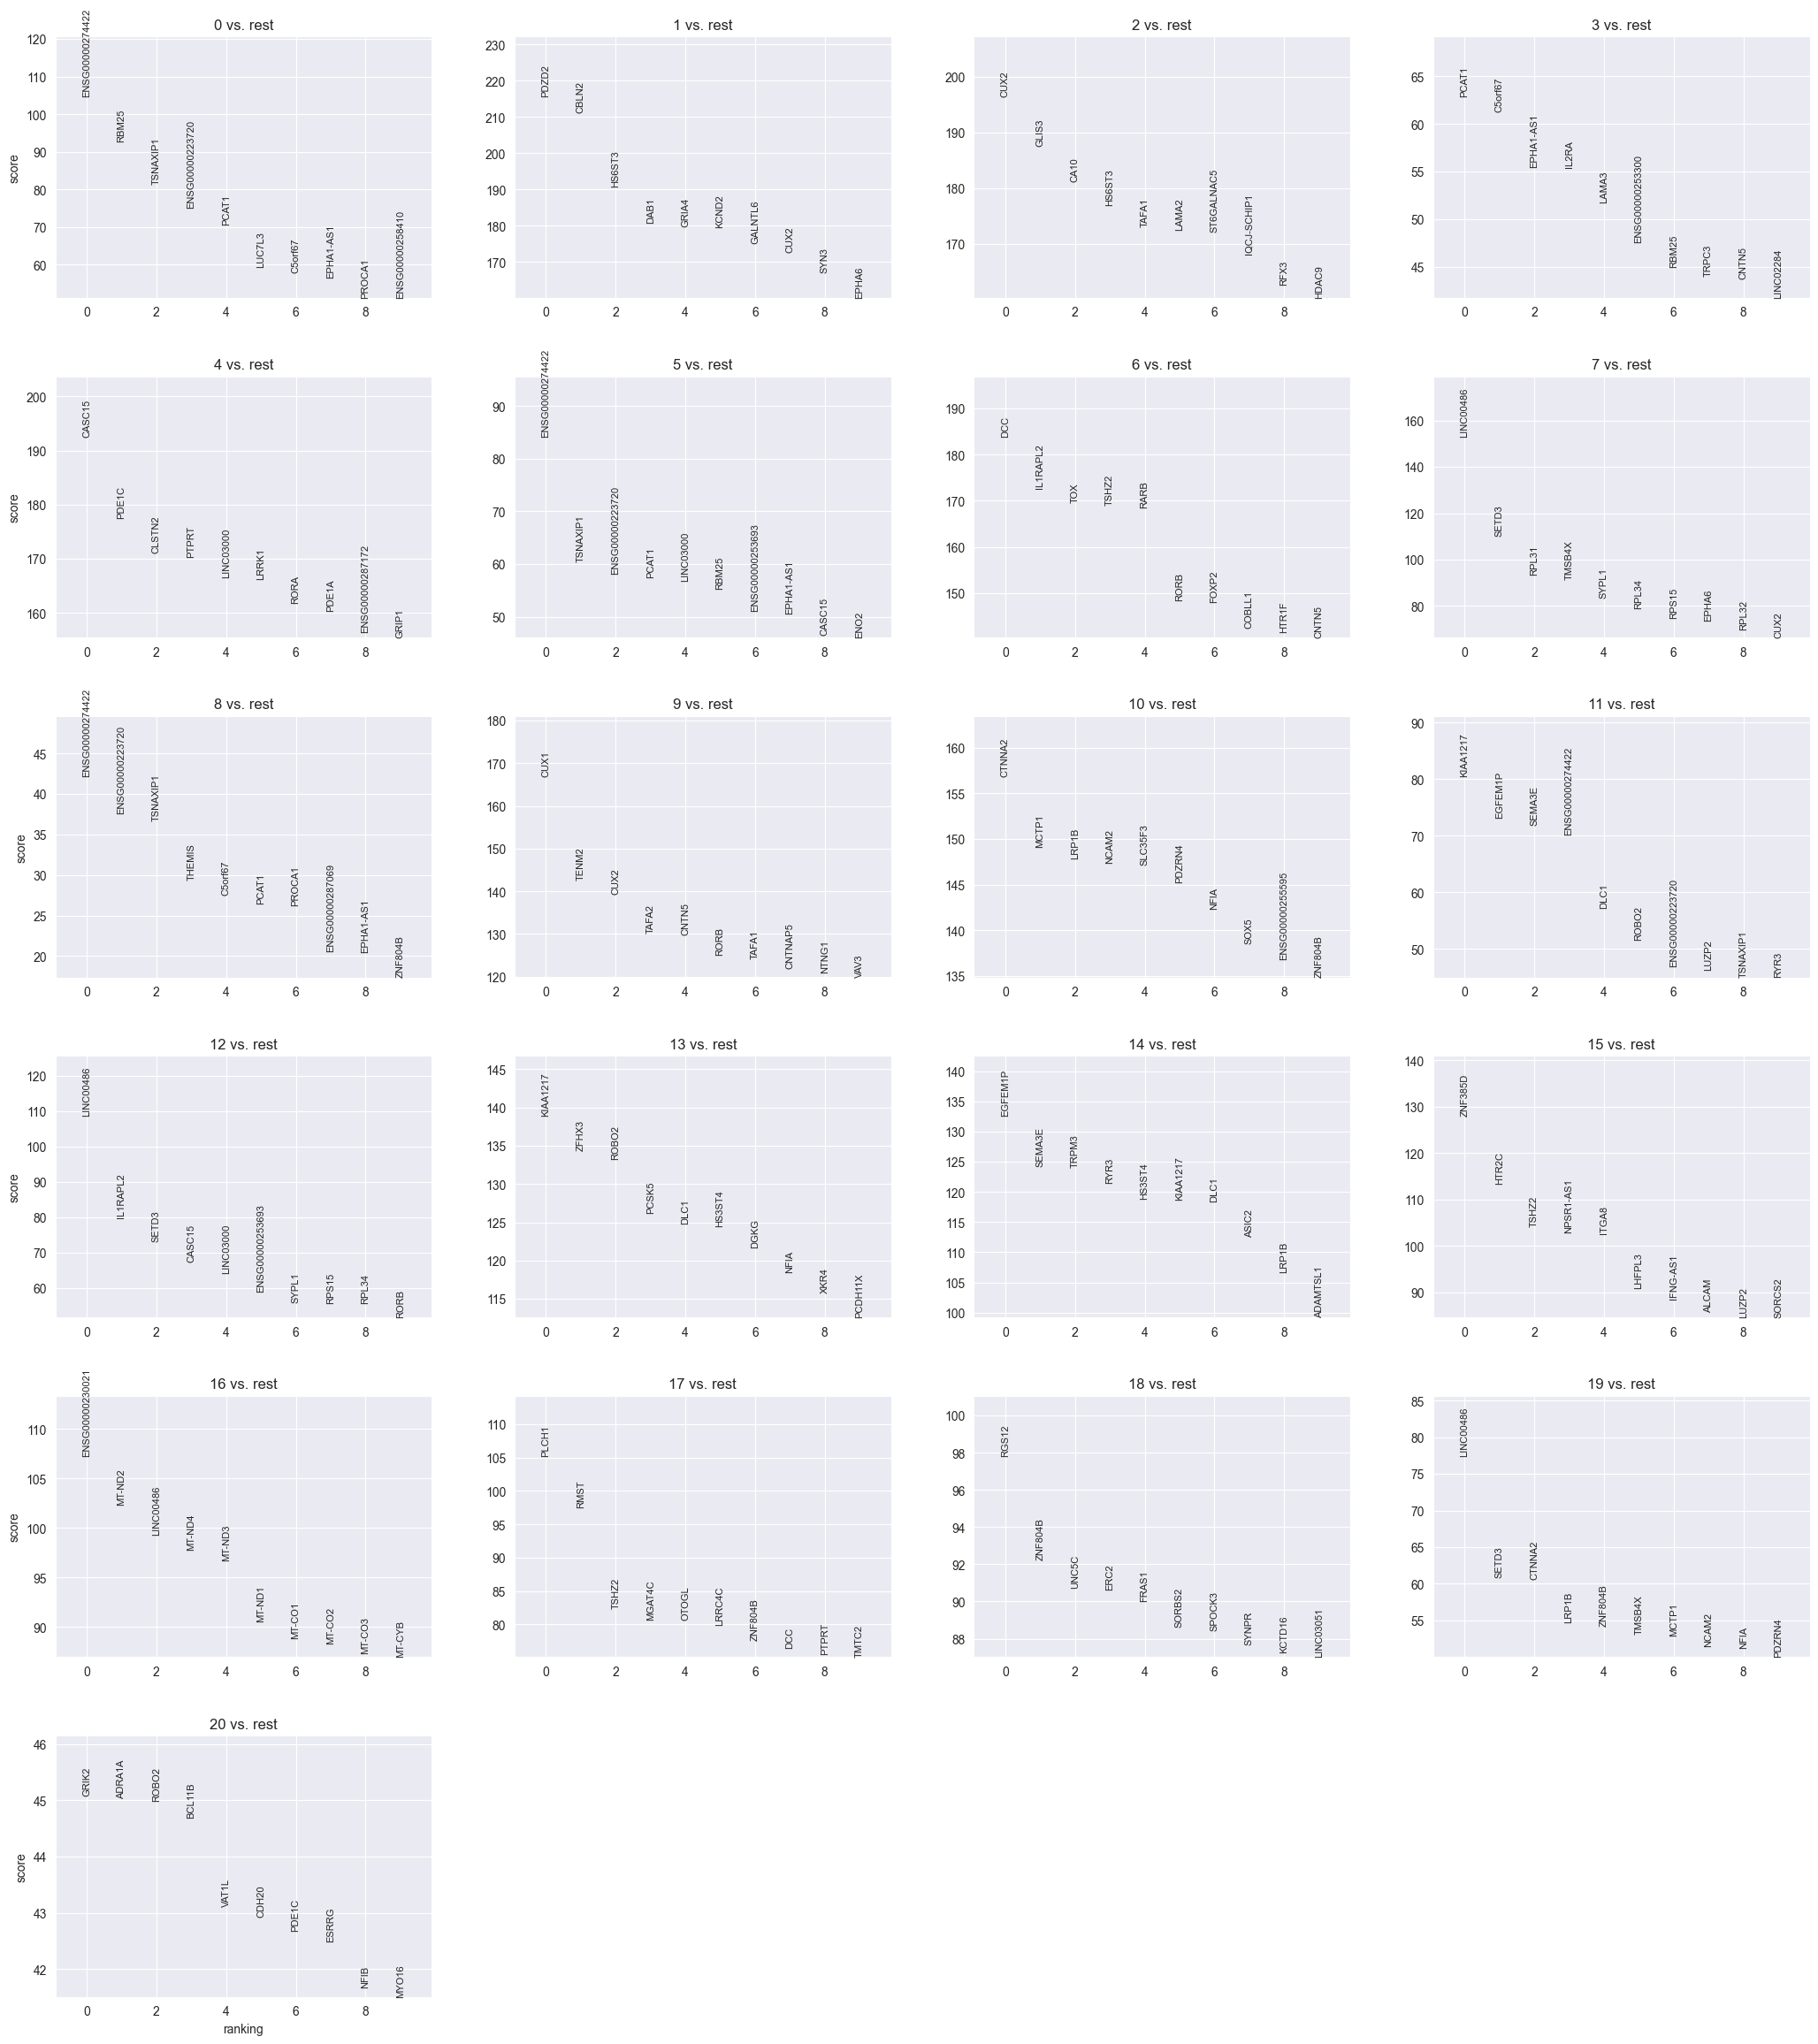

In [14]:
sc.pl.rank_genes_groups(adata_hvg, n_genes=10, sharey=False, gene_symbols="feature_name")

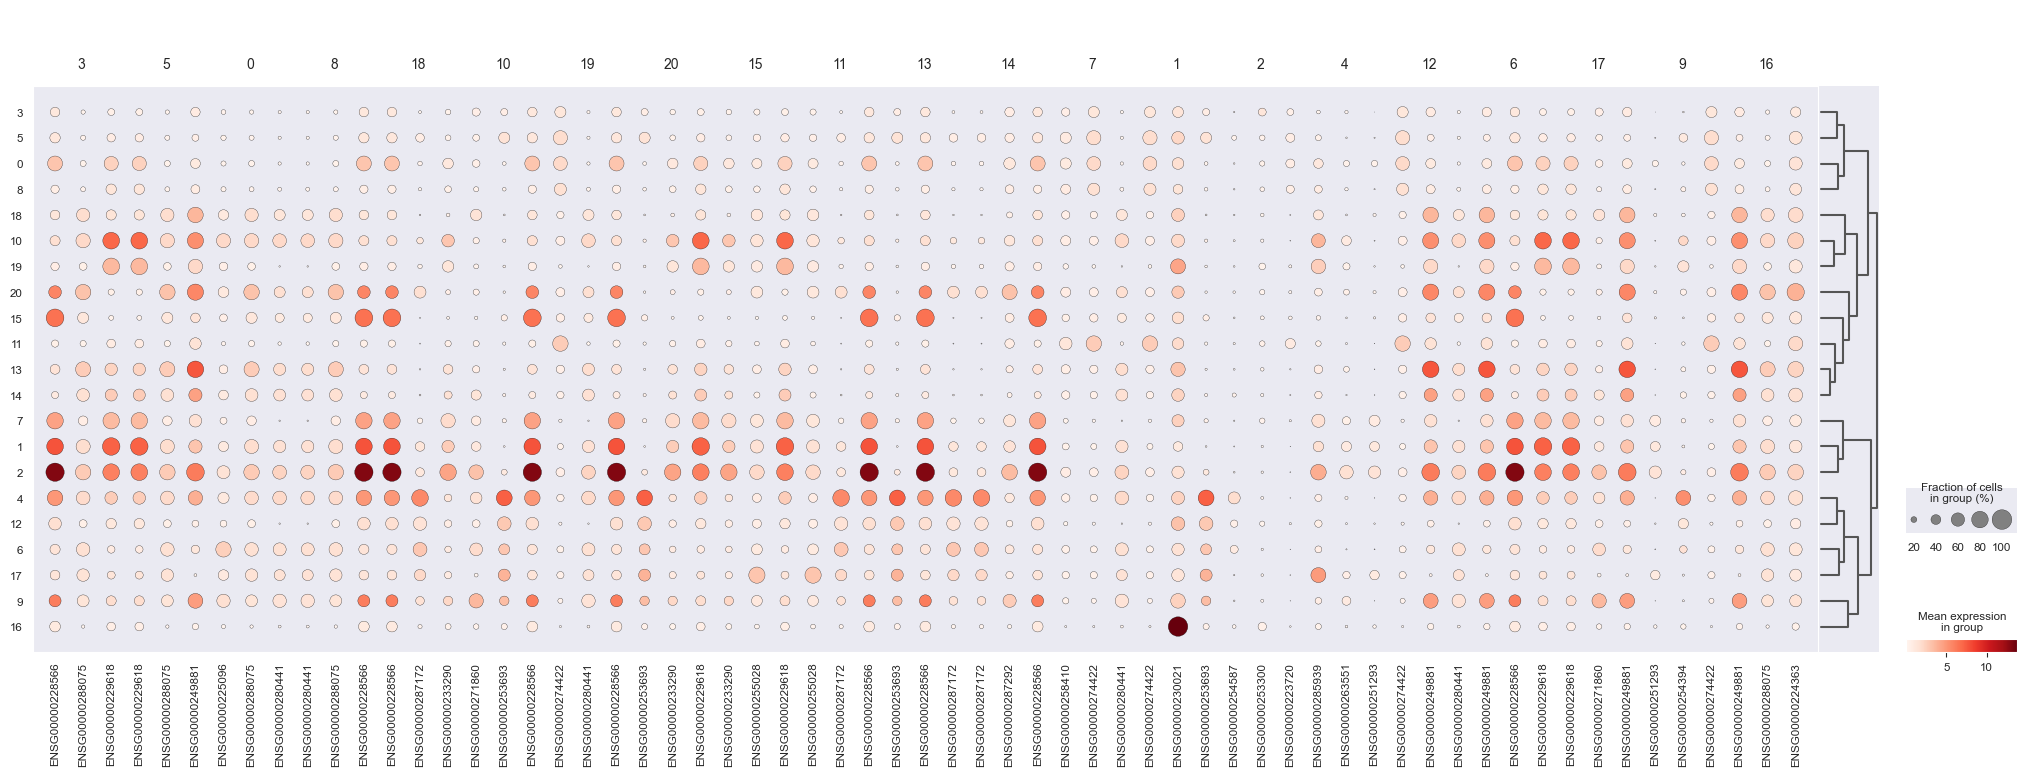

In [17]:
sc.pl.rank_genes_groups_dotplot(adata_hvg, n_genes=-3, gene_symbols="feature_name")

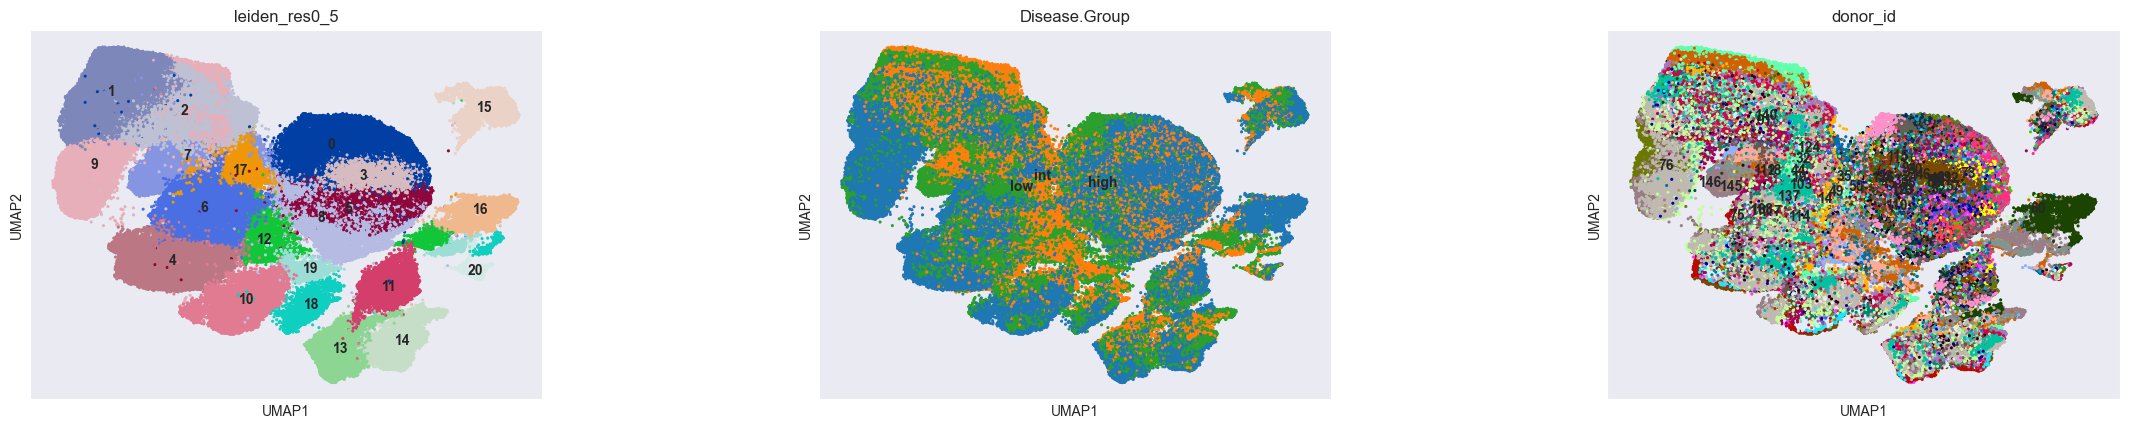

In [16]:
sc.pl.umap(adata_hvg, color=['leiden_res0_5', "Disease.Group", "donor_id"], wspace=0.4, size=20, legend_loc="on data")

In [103]:
normal = adata_hvg.obs[adata_hvg.obs["disease"] == "normal"]
alzheimers = adata_hvg.obs[adata_hvg.obs["disease"] != "normal"]

In [176]:
import pandas as pd
from scipy.stats import fisher_exact, chi2_contingency

# Calculate if there a global enrichement
ct = pd.crosstab(adata_hvg.obs['leiden_res0_5'], adata_hvg.obs['disease'])
chi2, p, dof, expected = chi2_contingency(ct[["Alzheimer disease","normal"]])
print(f"Global test p={p:.3e}")


pvals = {}
for i, row in ct.iterrows():
    a = row["Alzheimer disease"]
    b = row["normal"]
    c = ct["Alzheimer disease"].sum() - a
    d = ct["normal"].sum() - b
    _, pval = fisher_exact([[a,b],[c,d]])
    pvals[row.name] = pval

# Calculate Clusters that are  significantly enriched in Alzheimers Disease (method fails and needs to be fixed)
pvals = pd.Series(pvals).sort_values()
print("\nTop enriched clusters (smallest p-values):")
print(pvals)

Global test p=0.000e+00

Top enriched clusters (smallest p-values):
0      0.000000e+00
12     0.000000e+00
19     0.000000e+00
3      0.000000e+00
16     0.000000e+00
7      0.000000e+00
5     8.740056e-318
8     2.220767e-124
11    1.950638e-105
4      3.505792e-76
2      1.945436e-65
14     1.098610e-52
18     1.073339e-37
6      4.047084e-35
9      8.434049e-27
13     5.835327e-25
17     1.238637e-14
1      1.399780e-10
20     6.035400e-09
15     7.200362e-08
10     6.583626e-05
dtype: float64


In [193]:
# Compositional Analysis - Takes into account other varying biological factors
import pertpy as pt

sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata_hvg,
    type="cell_level",
    generate_sample_level=True,
    sample_identifier="donor_id",
    cell_type_identifier="leiden_res0_5",
    covariate_obs=["disease"]
)

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/mudata/_core/mudata.py:616: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


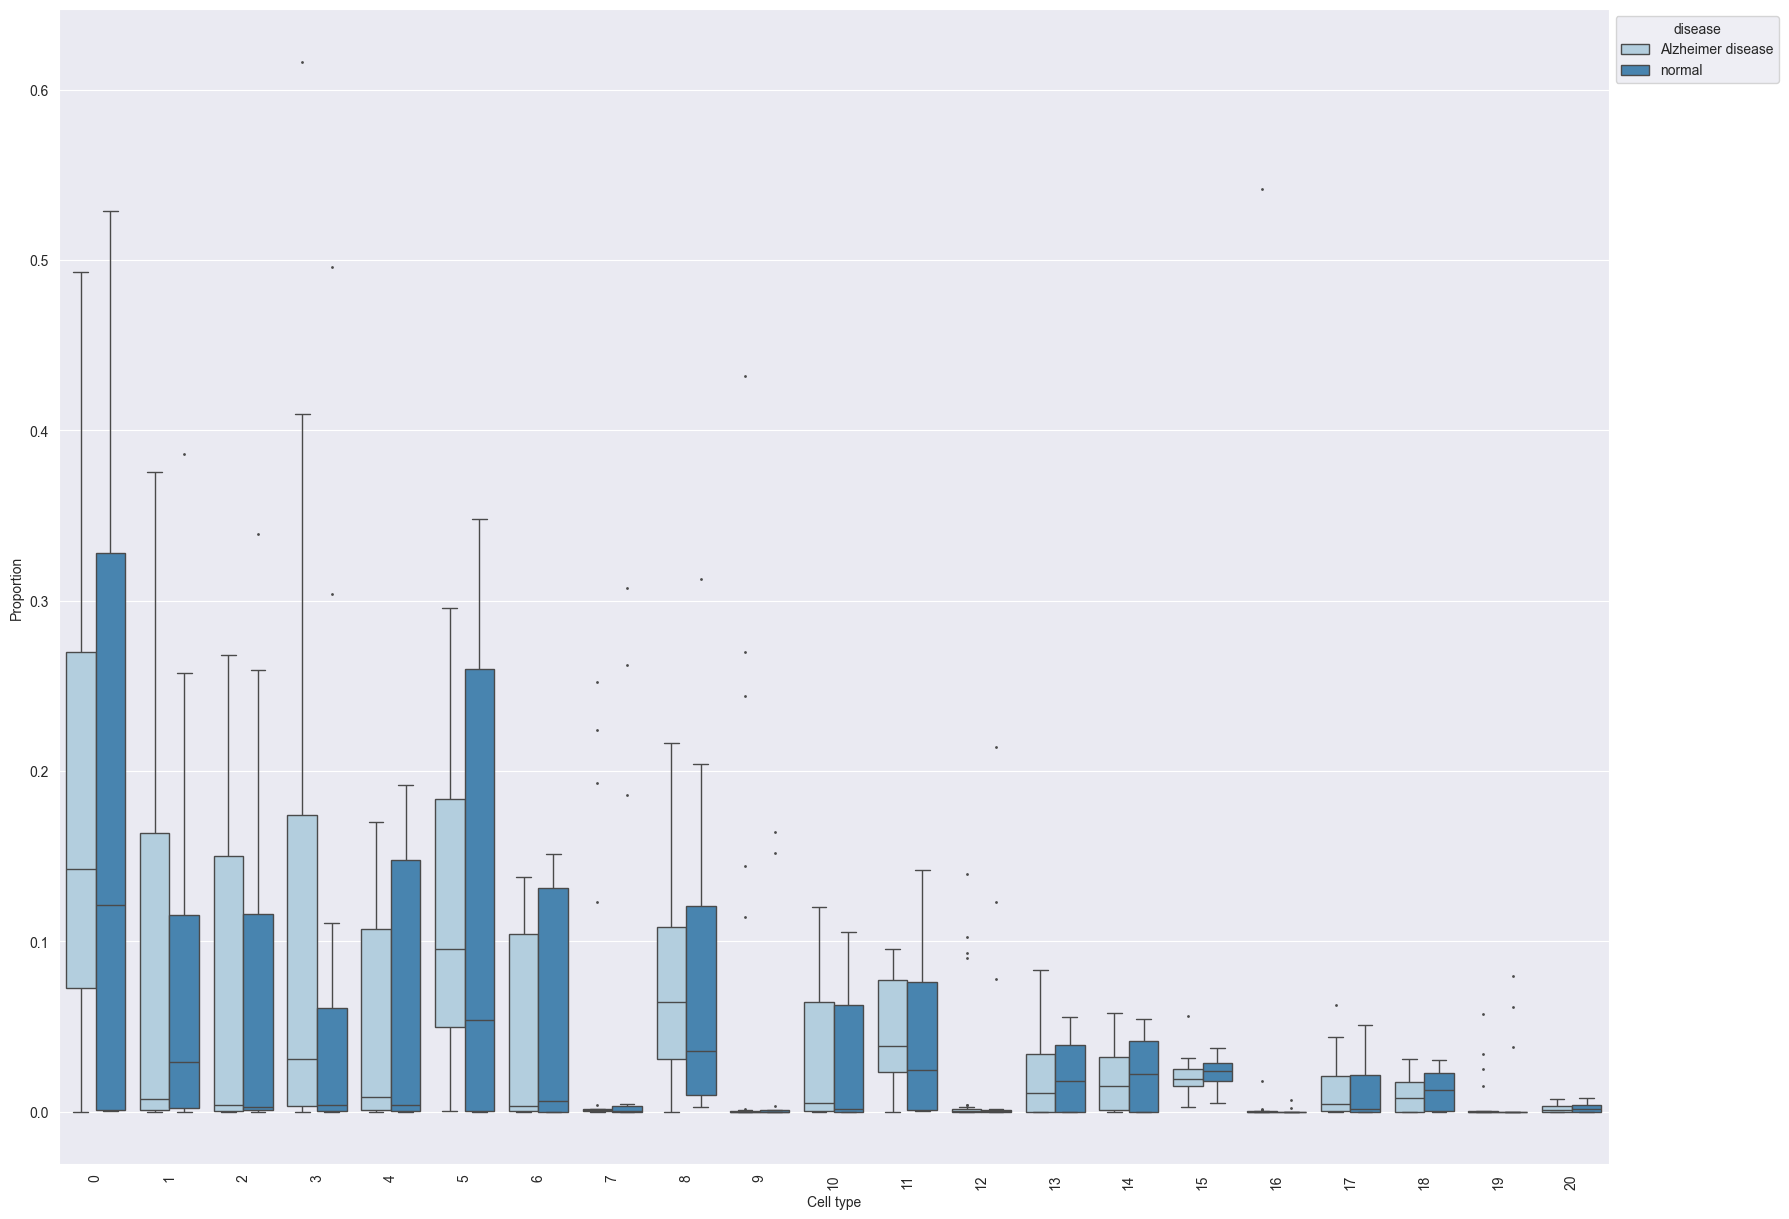

In [207]:
sccoda_model.plot_boxplots(
    sccoda_data,
    modality_key="coda",
    feature_name="disease",
    figsize=(20, 15),
)

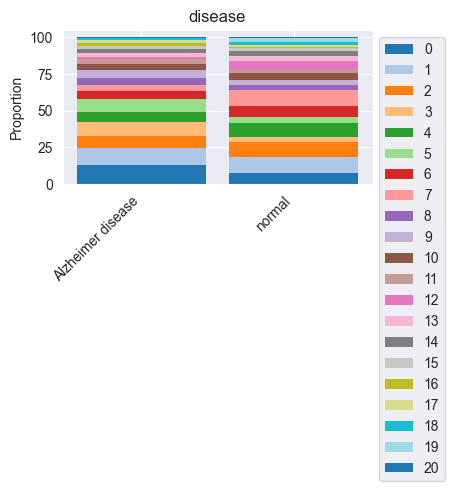

In [208]:
sccoda_model.plot_stacked_barplot(
    sccoda_data, modality_key="coda", feature_name="disease", figsize=(4, 2)
)

In [215]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="disease",
    reference_cell_type="automatic",
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda")

• Automatic reference selection! Reference cell type set to 20


sample: 100%|██████████| 11000/11000 [01:43<00:00, 106.68it/s, 63 steps of size 4.99e-02. acc. prob=0.82] 


In [216]:
sccoda_data["coda"].varm["effect_df_disease[T.normal]"]

Final Parameter  HDI 3%  HDI 97%     SD  Inclusion probability  \
leiden_res0_5                                                                   
0                          0.0  -0.769    0.083  0.259                 0.7375   
1                          0.0  -0.291    0.314  0.106                 0.4637   
2                          0.0  -0.314    0.306  0.107                 0.4681   
3                          0.0  -0.680    0.106  0.204                 0.6154   
4                          0.0  -0.299    0.336  0.109                 0.4757   
5                          0.0  -0.706    0.105  0.222                 0.6503   
6                          0.0  -0.316    0.321  0.111                 0.4780   
7                          0.0  -0.314    0.326  0.110                 0.4778   
8                          0.0  -0.361    0.235  0.109                 0.4735   
9                          0.0  -0.240    0.399  0.113                 0.4773   
10                         0.0  -0.327    0.288  0.109                 0.4730   
11                         0.0  -0.467    0.182  0.135                 0.5163   
12                         0.0  -0.302    0.349  0.116                 0.4880   
13                         0.0  -0.327    0.308  0.111                 0.4776   
14                         0.0  -0.360    0.305  0.113                 0.4680   
15                         0.0  -0.312    0.312  0.107                 0.4774   
16                         0.0  -0.267    0.353  0.109                 0.4807   
17                         0.0  -0.321    0.300  0.108                 0.4740   
18                         0.0  -0.295    0.314  0.109                 0.4843   
19                         0.0  -0.276    0.361  0.119                 0.4913   
20                         0.0   0.000    0.000  0.000                 0.0000   

               Expected Sample  log2-fold change  
leiden_res0_5                                     
0                   684.603891               0.0  
1                   341.326812               0.0  
2                   260.822581               0.0  
3                   345.102133               0.0  
4                   294.076639               0.0  
5                   533.170047               0.0  
6                   270.924561               0.0  
7                   175.710967               0.0  
8                   556.596416               0.0  
9                   147.059962               0.0  
10                  251.599971               0.0  
11                  395.377265               0.0  
12                  161.715790               0.0  
13                  240.528939               0.0  
14                  251.851697               0.0  
15                  391.834834               0.0  
16                  124.815970               0.0  
17                  214.828581               0.0  
18                  217.422053               0.0  
19                  130.169886               0.0  
20                  163.504483               0.0

In [218]:
print(sccoda_model.credible_effects(sccoda_data, modality_key="coda"))

Covariate          Cell Type
disease[T.normal]  0            False
                   1            False
                   2            False
                   3            False
                   4            False
                   5            False
                   6            False
                   7            False
                   8            False
                   9            False
                   10           False
                   11           False
                   12           False
                   13           False
                   14           False
                   15           False
                   16           False
                   17           False
                   18           False
                   19           False
                   20           False
Name: Final Parameter, dtype: bool


In [12]:
import scvi
import numpy as np
adata_hvg.layers["counts"] = adata_hvg.X.copy()

adata_scvi = adata_hvg.copy()
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key="donor_id")
model_scvi = scvi.model.SCVI(adata_scvi)
max_epochs_scvi = 30
model_scvi.train(max_epochs=max_epochs_scvi, accelerator='gpu')

adata_hvg.obsm["X_scVI"] = model_scvi.get_latent_representation()

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch/Jax operations are supported with this backend. as a result, some models might be slower and less accurate than usuall. Please verify your analysis!Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_

Epoch 1/30:   0%|          | 0/30 [00:00<?, ?it/s]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 2/30:   3%|▎         | 1/30 [00:58<28:15, 58.46s/it, v_num=1, train_loss_step=766, train_loss_epoch=800]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 3/30:   7%|▋         | 2/30 [01:54<26:35, 56.97s/it, v_num=1, train_loss_step=747, train_loss_epoch=761]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 4/30:  10%|█         | 3/30 [03:18<31:13, 69.37s/it, v_num=1, train_loss_step=752, train_loss_epoch=752]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 5/30:  13%|█▎        | 4/30 [04:14<27:47, 64.12s/it, v_num=1, train_loss_step=740, train_loss_epoch=749]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 6/30:  17%|█▋        | 5/30 [05:10<25:31, 61.27s/it, v_num=1, train_loss_step=700, train_loss_epoch=747]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 7/30:  20%|██        | 6/30 [06:07<23:49, 59.55s/it, v_num=1, train_loss_step=751, train_loss_epoch=745]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 8/30:  23%|██▎       | 7/30 [07:03<22:23, 58.41s/it, v_num=1, train_loss_step=740, train_loss_epoch=745]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 9/30:  27%|██▋       | 8/30 [08:31<24:51, 67.81s/it, v_num=1, train_loss_step=742, train_loss_epoch=744]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 10/30:  30%|███       | 9/30 [09:27<22:28, 64.21s/it, v_num=1, train_loss_step=756, train_loss_epoch=744]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 11/30:  33%|███▎      | 10/30 [10:23<20:33, 61.67s/it, v_num=1, train_loss_step=742, train_loss_epoch=743]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 12/30:  37%|███▋      | 11/30 [11:19<18:58, 59.92s/it, v_num=1, train_loss_step=720, train_loss_epoch=743]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 13/30:  40%|████      | 12/30 [12:15<17:39, 58.87s/it, v_num=1, train_loss_step=745, train_loss_epoch=743]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 14/30:  43%|████▎     | 13/30 [13:12<16:31, 58.34s/it, v_num=1, train_loss_step=731, train_loss_epoch=743]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 15/30:  47%|████▋     | 14/30 [14:09<15:23, 57.72s/it, v_num=1, train_loss_step=767, train_loss_epoch=743]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 16/30:  50%|█████     | 15/30 [15:05<14:20, 57.35s/it, v_num=1, train_loss_step=802, train_loss_epoch=743]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 17/30:  53%|█████▎    | 16/30 [16:02<13:19, 57.09s/it, v_num=1, train_loss_step=735, train_loss_epoch=743]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 18/30:  57%|█████▋    | 17/30 [30:13<1:04:07, 295.97s/it, v_num=1, train_loss_step=780, train_loss_epoch=742]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 19/30:  60%|██████    | 18/30 [31:10<44:50, 224.22s/it, v_num=1, train_loss_step=743, train_loss_epoch=742]  

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 20/30:  63%|██████▎   | 19/30 [32:06<31:50, 173.66s/it, v_num=1, train_loss_step=758, train_loss_epoch=742]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 21/30:  67%|██████▋   | 20/30 [33:02<23:03, 138.34s/it, v_num=1, train_loss_step=709, train_loss_epoch=742]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 22/30:  70%|███████   | 21/30 [35:54<22:14, 148.30s/it, v_num=1, train_loss_step=712, train_loss_epoch=742]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 23/30:  73%|███████▎  | 22/30 [36:50<16:05, 120.65s/it, v_num=1, train_loss_step=772, train_loss_epoch=742]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 24/30:  77%|███████▋  | 23/30 [37:47<11:50, 101.47s/it, v_num=1, train_loss_step=748, train_loss_epoch=742]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 25/30:  80%|████████  | 24/30 [38:43<08:47, 88.00s/it, v_num=1, train_loss_step=716, train_loss_epoch=742] 

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 26/30:  83%|████████▎ | 25/30 [1:00:33<37:53, 454.70s/it, v_num=1, train_loss_step=722, train_loss_epoch=742]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 27/30:  87%|████████▋ | 26/30 [1:01:29<22:20, 335.07s/it, v_num=1, train_loss_step=792, train_loss_epoch=742]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 28/30:  90%|█████████ | 27/30 [1:02:25<12:33, 251.30s/it, v_num=1, train_loss_step=774, train_loss_epoch=742]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 29/30:  93%|█████████▎| 28/30 [1:09:39<10:11, 305.95s/it, v_num=1, train_loss_step=720, train_loss_epoch=742]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 30/30:  97%|█████████▋| 29/30 [1:10:36<03:51, 231.22s/it, v_num=1, train_loss_step=734, train_loss_epoch=742]

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 30/30: 100%|██████████| 30/30 [1:11:32<00:00, 178.69s/it, v_num=1, train_loss_step=750, train_loss_epoch=742]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|██████████| 30/30 [1:11:32<00:00, 143.07s/it, v_num=1, train_loss_step=750, train_loss_epoch=742]


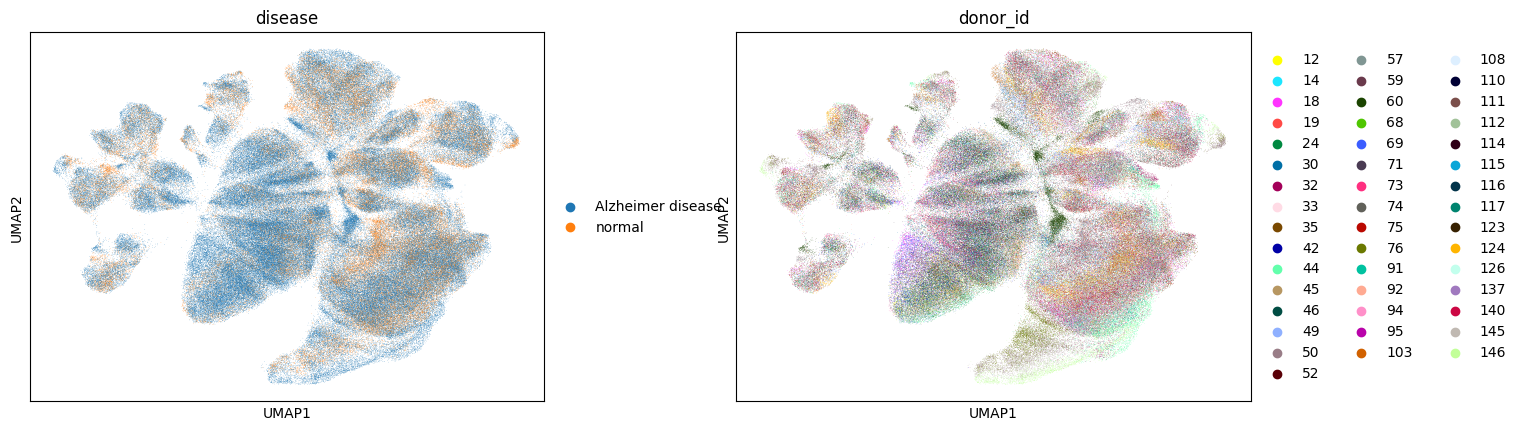

In [14]:
sc.pp.neighbors(adata_hvg, use_rep="X_scVI")
sc.tl.umap(adata_hvg)

sc.pl.umap(adata_hvg, color=["disease", "donor_id"], ncols=3, wspace=0.25)

In [ ]:
adata_hvg.write("data/dataset_glutamatergic_latest_state.h5ad")

In [1]:
import scanpy as sc
adata_hvg = sc.read("data/dataset_glutamatergic_latest_state.h5ad")

In [2]:
import pertpy as pt

milo = pt.tl.Milo()
mdata = milo.load(adata_hvg)

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
milo.make_nhoods(mdata, prop=0.02)

In [5]:
import numpy as np
adata_hvg.obsm["nhoods"]
nhood_size = adata_hvg.obsm["nhoods"].toarray().sum(0)
np.median(nhood_size)

np.float32(24.0)

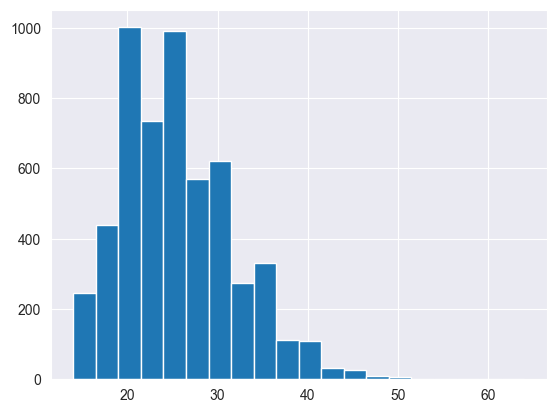

In [6]:
import matplotlib.pyplot as plt
plt.hist(nhood_size, bins=20)
plt.show()

In [12]:
neighbours = 46 * 15
sc.pp.neighbors(adata_hvg, n_neighbors=neighbours, use_rep="X_scVI", key_added="milo")

In [34]:
import numpy as np

milo.make_nhoods(mdata, neighbors_key="milo", prop=0.03)
adata_hvg.obsm["nhoods"]
nhood_size = adata_hvg.obsm["nhoods"].toarray().sum(0)
np.median(nhood_size)

np.float32(1276.0)

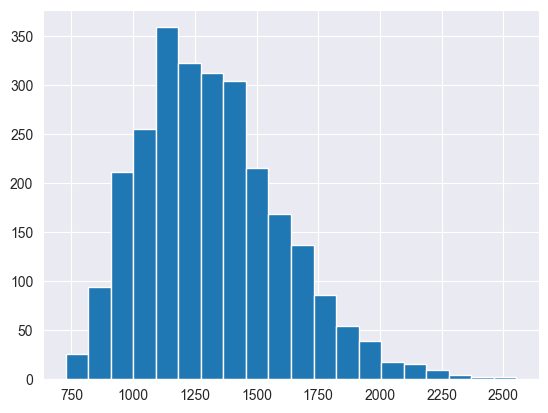

In [28]:
import matplotlib.pyplot as plt
plt.hist(nhood_size, bins=20)
plt.show()

In [29]:
milo.count_nhoods(mdata, sample_col="donor_id")

MuData object with n_obs × n_vars = 282930 × 5000
  2 modalities
    rna:	282930 x 5000
      obs:	'APOE_class', 'Brain.Region', 'SORT', 'Braak.stage', 'Disease.Group', 'Amyloid', 'Brain.weight', 'PMI.hr.', 'Race', 'Age', 'RIN', 'total_counts', 'pct_counts_mt', 'droplet_FDR', 'doublefinder', 'n_genes', 'sample', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'donor_id', 'Age_group', 'PMI_group', 'RIN_group', 'Major_celltypes', 'Author_Annotation', 'NP.Diagonis', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'mt', 'ribo', 'hb', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'Author_Annotation_colors', 'cell_type_colors', 'citation', 'disease_colors', 'donor_id_colors', 'hvg', 'neighbors', 'nhood_neighbors_key', 'organism', 'organism_ontology_term_id', 'pca', 'schema_reference', 'schema_version', 'title', 'umap', 'milo'
      obsm:	'X_pca', 'X_pca_harmony', 'X_scVI', 'X_umap', 'nhoods'
      varm:	'PCs'
      layers:	'counts', 'spliced', 'unspliced'
      obsp:	'connectivities', 'distances', 'milo_distances', 'milo_connectivities'
    milo:	46 x 2635
      var:	'index_cell', 'kth_distance'
      uns:	'sample_col'

Text(0, 0.5, 'Mean # cells per sample in nhood')

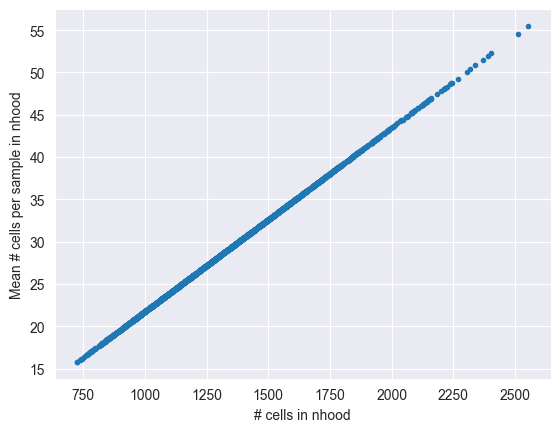

In [30]:
mean_n_cells = mdata["milo"].X.toarray().mean(0)
plt.plot(nhood_size, mean_n_cells, ".")
plt.xlabel("# cells in nhood")
plt.ylabel("Mean # cells per sample in nhood")

In [31]:
adata_hvg.obs["disease"].value_counts()

disease
Alzheimer_disease    207990
normal                74940
Name: count, dtype: int64

In [32]:
adata_hvg.obs["disease"].unique()
adata_hvg.obs["disease"] = adata_hvg.obs["disease"].str.replace(" ", "_")


               disease donor_id
12   Alzheimer_disease       12
14   Alzheimer_disease       14
18   Alzheimer_disease       18
19   Alzheimer_disease       19
24   Alzheimer_disease       24
30   Alzheimer_disease       30
32   Alzheimer_disease       32
33   Alzheimer_disease       33
35   Alzheimer_disease       35
42   Alzheimer_disease       42
44   Alzheimer_disease       44
45   Alzheimer_disease       45
46   Alzheimer_disease       46
49              normal       49
50              normal       50
52   Alzheimer_disease       52
57   Alzheimer_disease       57
59   Alzheimer_disease       59
60   Alzheimer_disease       60
68   Alzheimer_disease       68
69   Alzheimer_disease       69
71              normal       71
73   Alzheimer_disease       73
74   Alzheimer_disease       74
75   Alzheimer_disease       75
76   Alzheimer_disease       76
91              normal       91
92   Alzheimer_disease       92
94              normal       94
95              normal       95
103     

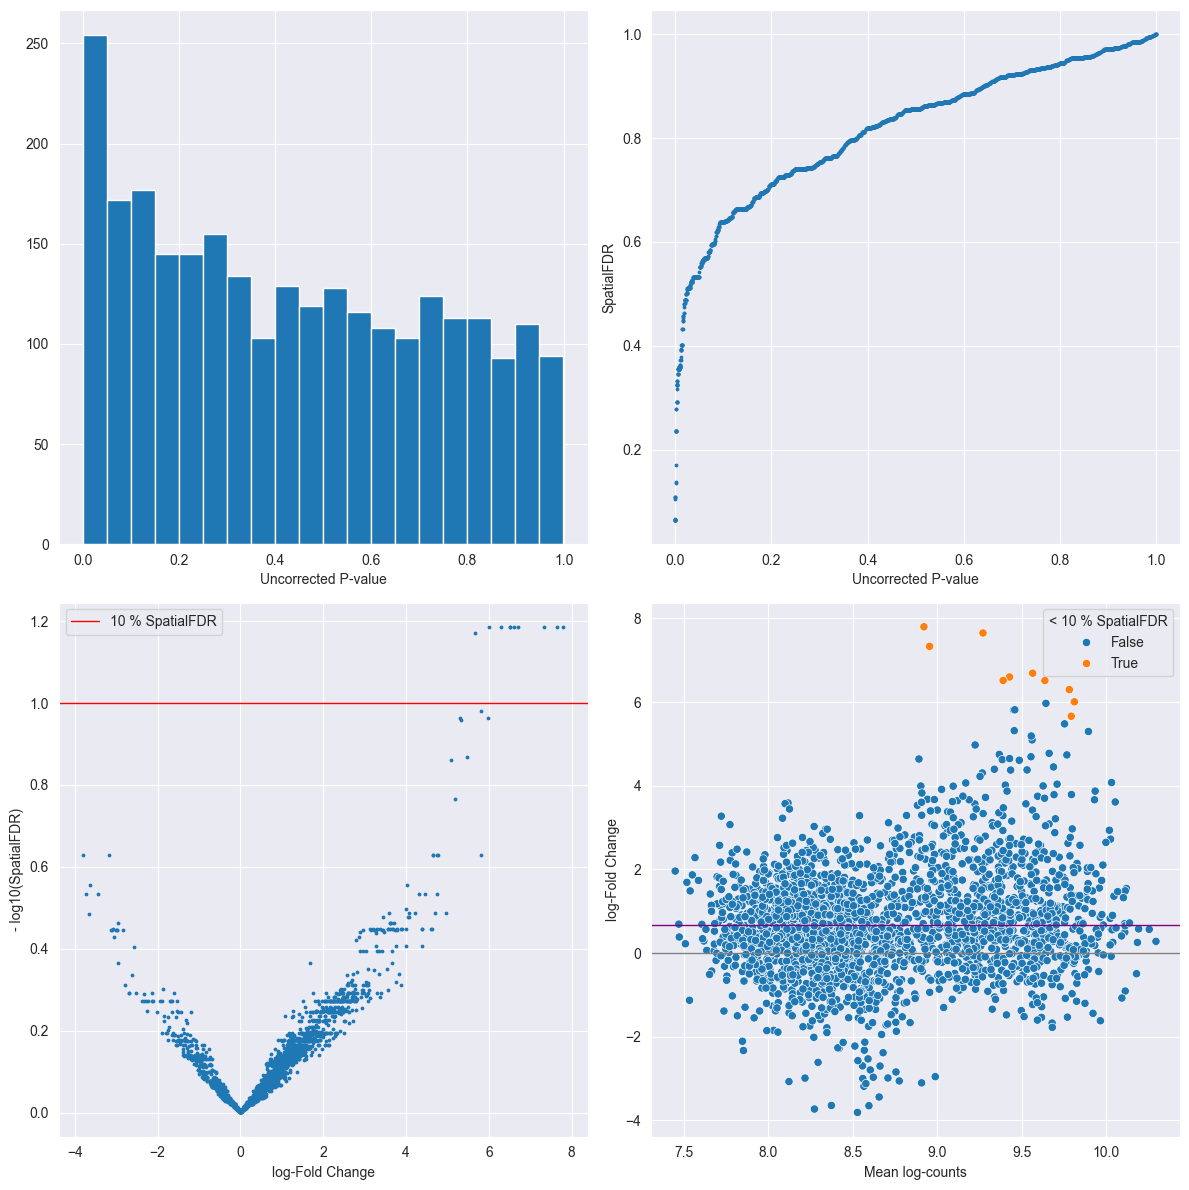

In [33]:
import matplotlib
import seaborn as sns

milo.da_nhoods(
    mdata,
    design="~disease",
    model_contrasts="diseaseAlzheimer_disease - diseasenormal"
)

ds = mdata["milo"].obs.copy()
print(ds)
def plot_milo_diagnostics(mdata):
    alpha = 0.1  ## significance threshold

    with matplotlib.rc_context({"figure.figsize": [12, 12]}):
        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(mdata["milo"].var["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(
            mdata["milo"].var["PValue"],
            mdata["milo"].var["SpatialFDR"],
            s=3,
        )
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            mdata["milo"].var["logFC"],
            -np.log10(mdata["milo"].var["SpatialFDR"]),
            s=3,
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = mdata["milo"].var
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()


plot_milo_diagnostics(mdata)

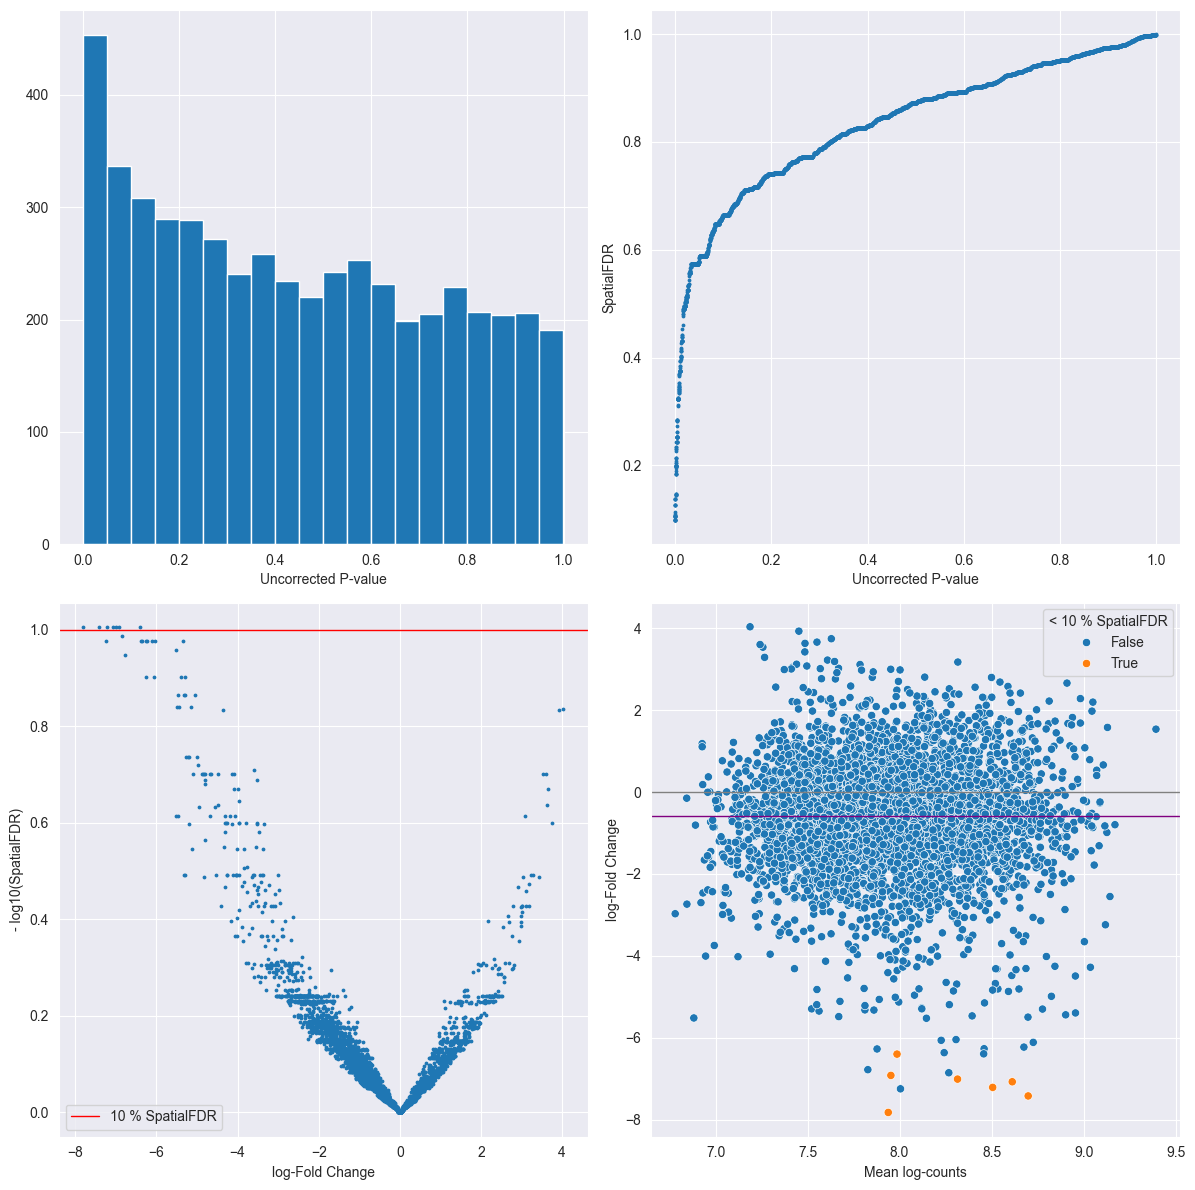

In [18]:
import matplotlib
import seaborn as sns

milo.da_nhoods(
    mdata,
    design="~disease",
    model_contrasts="diseasenormal-diseaseAlzheimer_disease"
)

ds = mdata["milo"].obs.copy()
print(ds)
def plot_milo_diagnostics(mdata):
    alpha = 0.1  ## significance threshold

    with matplotlib.rc_context({"figure.figsize": [12, 12]}):
        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(mdata["milo"].var["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(
            mdata["milo"].var["PValue"],
            mdata["milo"].var["SpatialFDR"],
            s=3,
        )
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            mdata["milo"].var["logFC"],
            -np.log10(mdata["milo"].var["SpatialFDR"]),
            s=3,
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = mdata["milo"].var
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()


plot_milo_diagnostics(mdata)

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


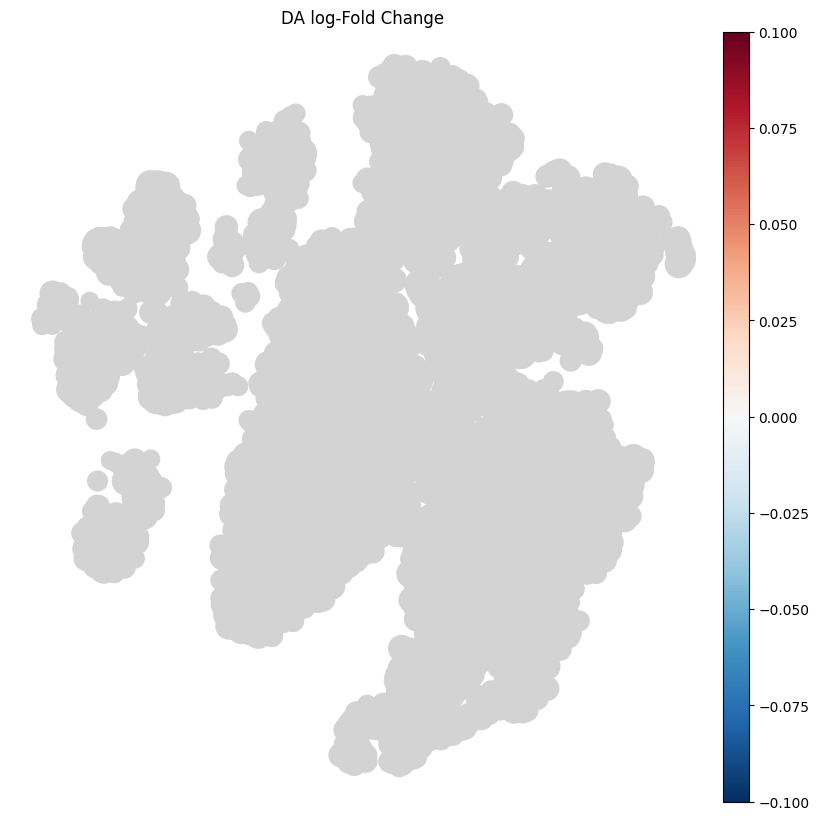

In [53]:
milo.build_nhood_graph(mdata)
with matplotlib.rc_context({"figure.figsize": [10, 10]}):
    milo.plot_nhood_graph(mdata, alpha=0.1, min_size=5, plot_edges=False)